# Interactive inference

In [1]:
from models.single_policy import SinglePolicy
from single_agent import SingleAgent
from IPython.display import SVG, display, HTML
import torch
from torch import distributions
import pdb
import vh_graph
import gym
import envdataset
import utils_viz
import utils
import sys
from IPython.display import Image
sys.argv = ['-f'] 

In [2]:
curr_env = gym.make('vh_graph-v0')

In [3]:
weights = 'logdir/dataset_folder.dataset_toy3_pomdp.False_graphsteps.3/2019-11-06_09.14.31.202175/chkpt/chkpt_49.pt'

In [4]:
# Set up the policy
args = utils.read_args()
args.max_steps = 1
args.interactive = True
dataset_interactive = envdataset.EnvDataset(args, process_progs=False)
print('Starting model...')
policy_net = SinglePolicy(dataset_interactive).cuda()
policy_net = torch.nn.DataParallel(policy_net)
policy_net.eval()
if weights is not None:
    print('Loading weights')
    state_dict = torch.load(weights)
    policy_net.load_state_dict(state_dict['model_params'])

Getting objects from dataset_toy3/obj_names.json...
Starting model...
Loading weights


In [5]:

path_init_env = 'dataset_toy3/init_envs/TrimmedTestScene6_graph_42.json'
goal_name = {0:'(facing living_room[1] living_room[1])'}
curr_env.reset(path_init_env, goal_name)
curr_env.to_pomdp()
single_agent = SingleAgent(curr_env, goal_name, 0, dataset_interactive, policy_net)
gt_state = curr_env.vh_state.to_dict()

### Set the goal to find pencil 2026

In [6]:
id_agent = [x['id'] for x in gt_state['nodes'] if x['class_name'] == 'character'][0]
id_goal = 2026
goal_str = 'findnode_{}'.format(id_goal)


## View graph

Edges...


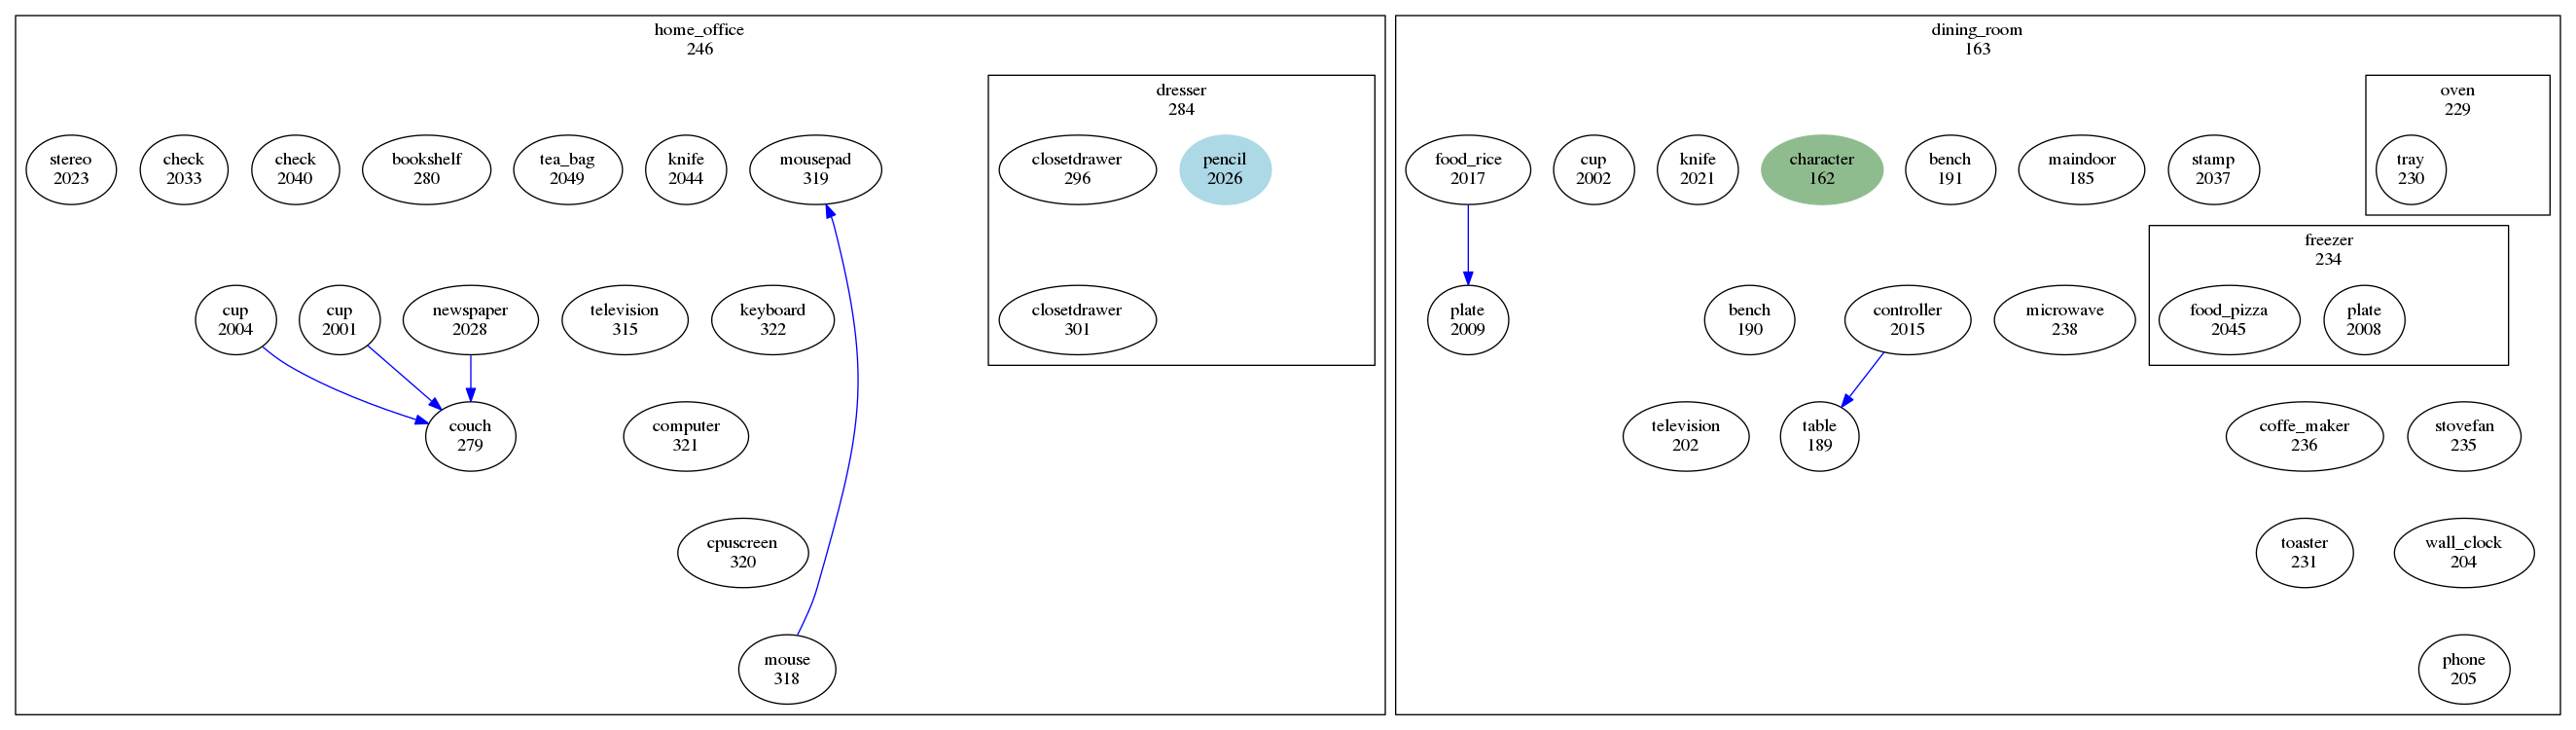

In [7]:
graph = utils_viz.graph2im(gt_state, {id_goal: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))

### Explore the model

Edges...
CLOSE_CHAR
CLOSE_CHAR
CLOSE_CHAR
CLOSE_CHAR
CLOSE_CHAR
CLOSE_CHAR


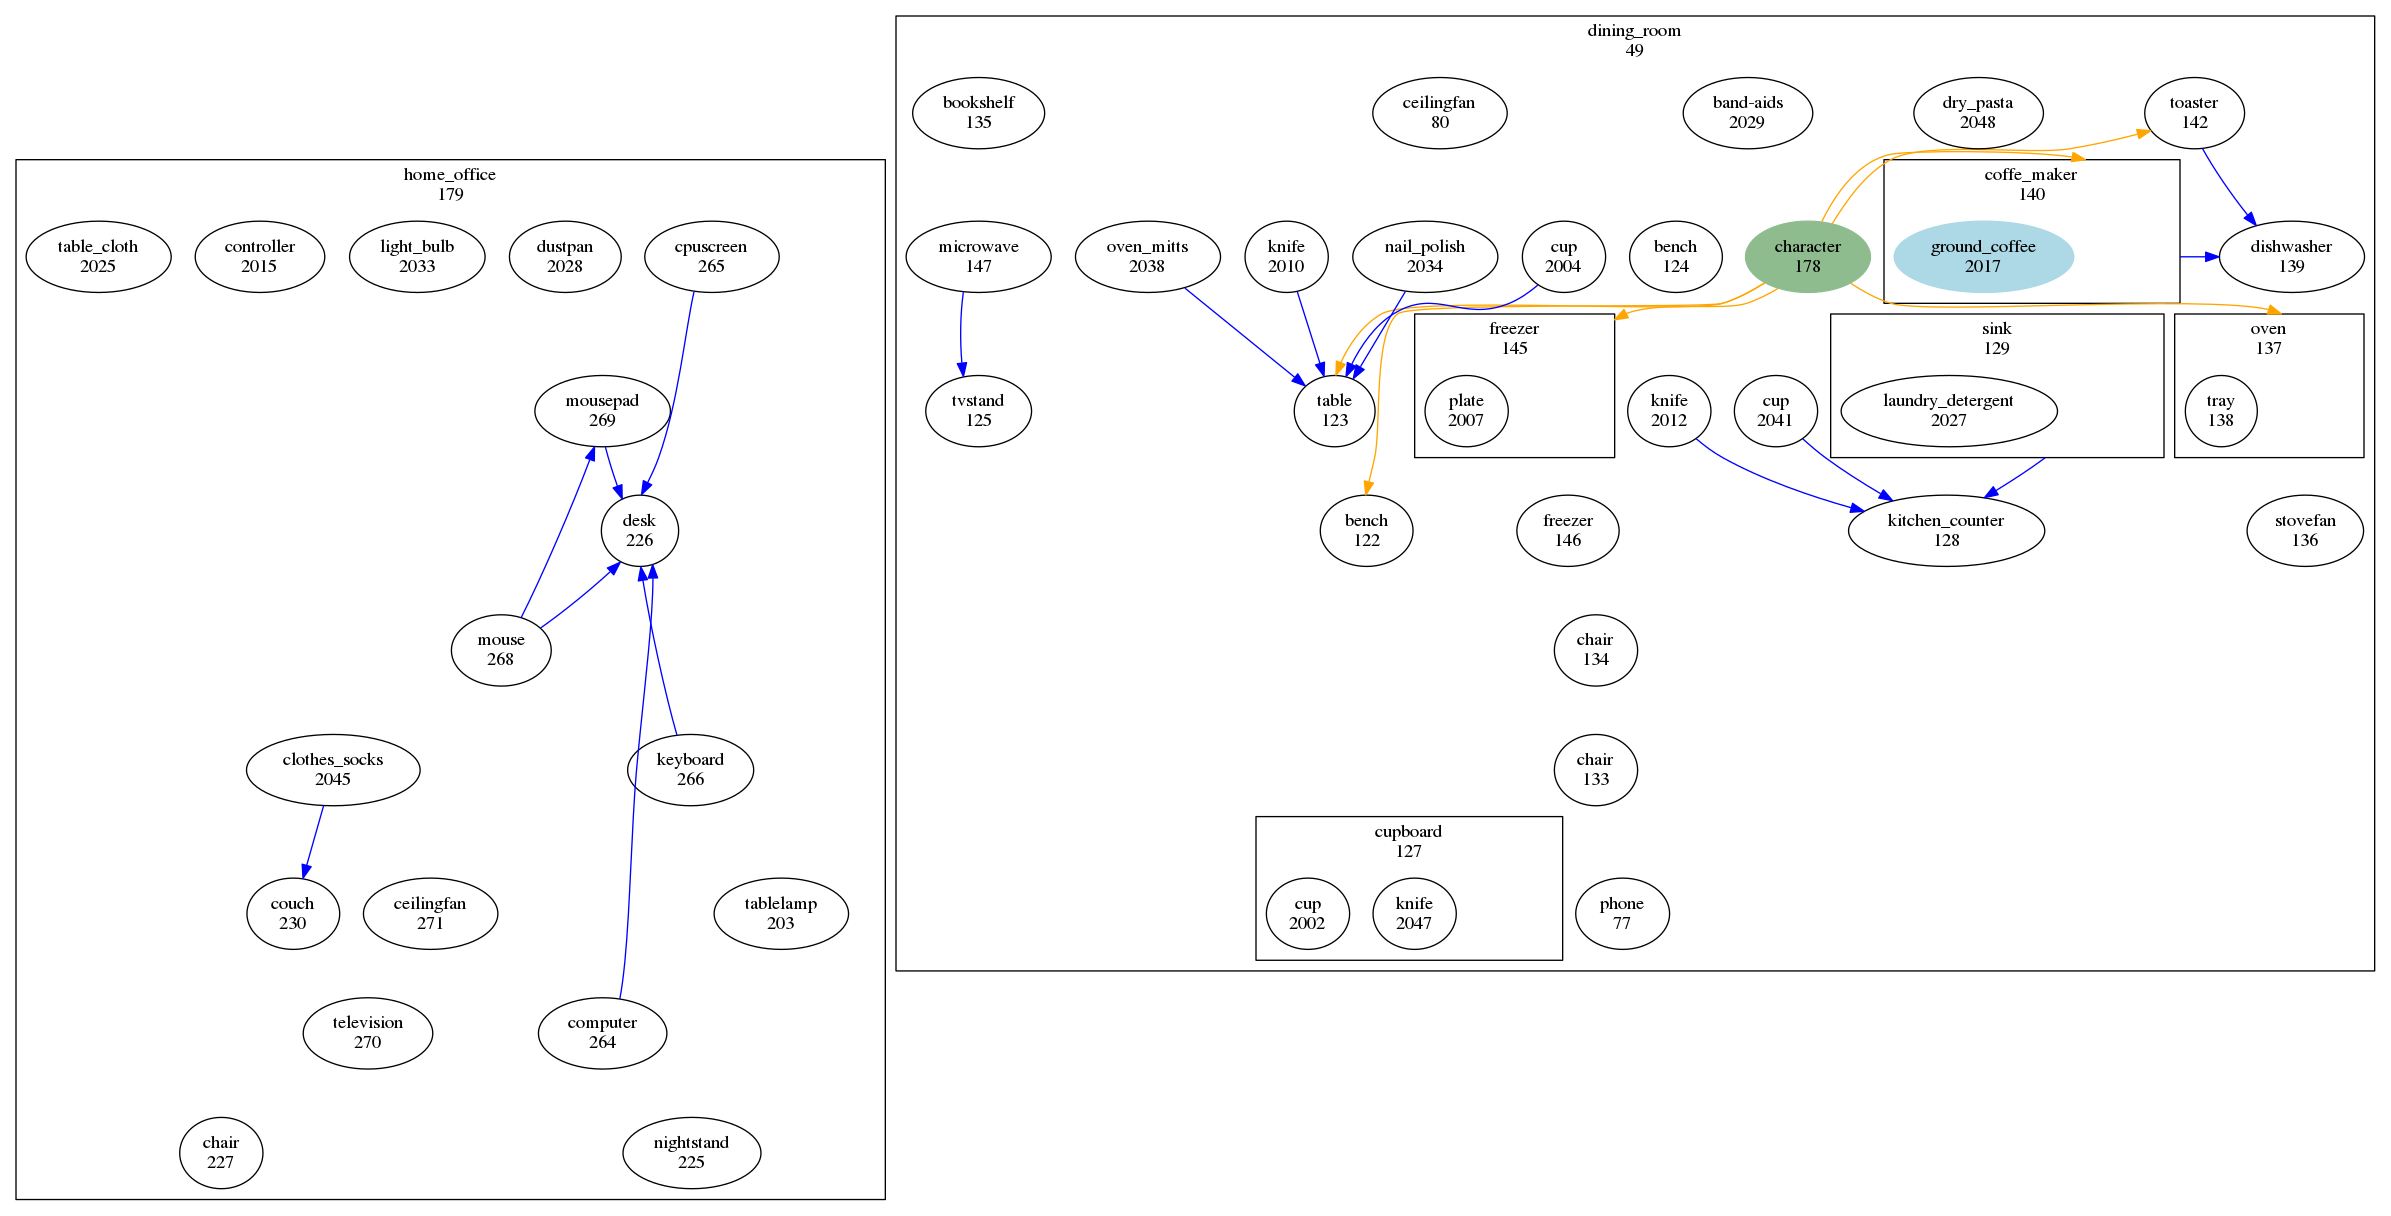

In [34]:
path_init_env = 'dataset_toy3/init_envs/TrimmedTestScene7_graph_30.json'

goal_name = {0:'(facing living_room[1] living_room[1])'}
curr_env.reset(path_init_env, goal_name)
curr_env.to_pomdp()
single_agent = SingleAgent(curr_env, goal_name, 0, dataset_interactive, policy_net)
gt_state = curr_env.vh_state.to_dict()
import json
with open('dataset_toy3/init_envs/TrimmedTestScene7_graph_30_multiple_439.json', 'r') as f:
    graph_multiple = json.load(f)
time = 0
gt_state = graph_multiple[time][1]

id_agent = [x['id'] for x in gt_state['nodes'] if x['class_name'] == 'character'][0]
id_goal = 2017
goal_string = 'findnode_{}'.format(id_goal)
graph = utils_viz.graph2im(gt_state, {id_goal: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))


In [38]:
# POMDP
weights = 'logdir/dataset_folder.dataset_toy3_pomdp.True_graphsteps.3_training_mode.bc/2019-11-07_12.40.50.558146/chkpt/chkpt_49.pt'
single_agent.policy_net.load_state_dict(torch.load(weights)['model_params'])
curr_state = single_agent.get_observations()

#curr_state['edges'] = [x for x in curr_state['edges'] if x['relation_type'] != 'CLOSE']
curr_state['edges'] = [x for x in curr_state['edges'] if x['relation_type'] != 'CLOSE' and x['from_id'] == 145 or x['to_id'] == 145]



visible_ids = None
graph_data, action_logits, o1_logits, o2_logits = single_agent.obtain_logits_from_observations(curr_state, visible_ids, goal_string)
instruction = single_agent.get_top_instruction(dataset_interactive, graph_data, action_logits, o1_logits, o2_logits)
instr = list(zip(*instruction))[0]
str_instruction = utils.pretty_instr(instr)
print(str_instruction)


# FOMDP
weights = 'logdir/dataset_folder.dataset_toy3_pomdp.False_graphsteps.3_training_mode.bc/2019-11-07_12.38.44.852796/chkpt/chkpt_49.pt'
single_agent.policy_net.load_state_dict(torch.load(weights)['model_params'])
curr_state = single_agent.env.vh_state.to_dict()

#curr_state['edges'] = [x for x in curr_state['edges'] if x['relation_type'] != 'CLOSE']
curr_state['edges'] = [x for x in curr_state['edges'] if x['relation_type'] != 'CLOSE' and x['from_id'] == 145 or x['to_id'] == 145]


visible_ids = single_agent.env.observable_object_ids_n[0]
graph_data, action_logits, o1_logits, o2_logits = single_agent.obtain_logits_from_observations(curr_state, visible_ids, goal_string)
instruction = single_agent.get_top_instruction(dataset_interactive, graph_data, action_logits, o1_logits, o2_logits)
instr = list(zip(*instruction))[0]
str_instruction = utils.pretty_instr(instr)
print(str_instruction)

[walk] <home_office> (179) 
[walk] <freezer> (145) 


### Multiple step rollout

In [139]:
def one_step_rollout(env, goal_string, pomdp):
    if pomdp:
        curr_state = single_agent.get_observations()
        visible_ids = None
    else:
        curr_state = single_agent.env.vh_state.to_dict()
        visible_ids = single_agent.env.observable_object_ids_n[0]
    
    graph_data, action_logits, o1_logits, o2_logits = single_agent.obtain_logits_from_observations(curr_state, visible_ids, goal_string)
    instruction, logits = single_agent.sample_instruction(dataset_interactive, graph_data, 
                                                          action_logits, o1_logits, o2_logits, pick_max=True)
    #instruction = single_agent.get_top_instruction(dataset_interactive, graph_data, action_logits, o1_logits, o2_logits)
    logits = None
    instr = list(zip(*instruction))[0]
    str_instruction = utils.pretty_instr(instr)
    if 'stop' in str_instruction:
            return None, str_instruction, logits
    resp = single_agent.env.step({0: str_instruction})
    return resp, str_instruction, logits

In [140]:
args.pomdp = False
weights = 'logdir/dataset_folder.dataset_toy3_pomdp.False_graphsteps.3/2019-11-06_09.14.31.202175/chkpt/chkpt_49.pt'
state_dict = torch.load(weights)
single_agent.policy_net.load_state_dict(state_dict['model_params'])

curr_env.reset(path_init_env, goal_name)
max_instr = 0
instr = ''
goal_str = 'findnode_315'
while max_instr < 10 and 'stop' not in instr:
    a = one_step_rollout(single_agent.env, goal_str, args.pomdp)
    instr = a[1]
    max_instr += 1
    print(instr)

Loading graph...
Loaded
[walk] <home_office> (246) 
[walk] <television> (315) 
[stop]  


In [141]:
curr_env.reset(path_init_env, goal_name)
max_instr = 0
instr = ''
goal_str = 'findnode_301'
while max_instr < 10 and 'stop' not in instr:
    a = one_step_rollout(single_agent.env, goal_str, args.pomdp)
    instr = a[1]
    max_instr += 1
    print(instr)

Loading graph...
Loaded
[walk] <home_office> (246) 
[walk] <dresser> (284) 
[open] <dresser> (284) 
[stop]  


### Back to non POMDP

In [142]:
%autoreload 2

In [143]:

path_init_env = "dataset_toy3/init_envs/TrimmedTestScene6_graph_28.json"
goal_name = '(facing living_room[1] living_room[1])'
curr_env.reset(path_init_env, {0: goal_name})
curr_env.to_pomdp()
single_agent = SingleAgent(curr_env, goal_name, 0, dataset_interactive, policy_net)

# Starting the scene
curr_state = single_agent.get_observations()
gt_state = single_agent.env.vh_state.to_dict()

# All the nodes
nodes, _, ids_used = dataset_interactive.process_graph(gt_state)
class_names, object_ids, _, mask_nodes, _ = nodes

Loading graph...
Loaded


Edges...


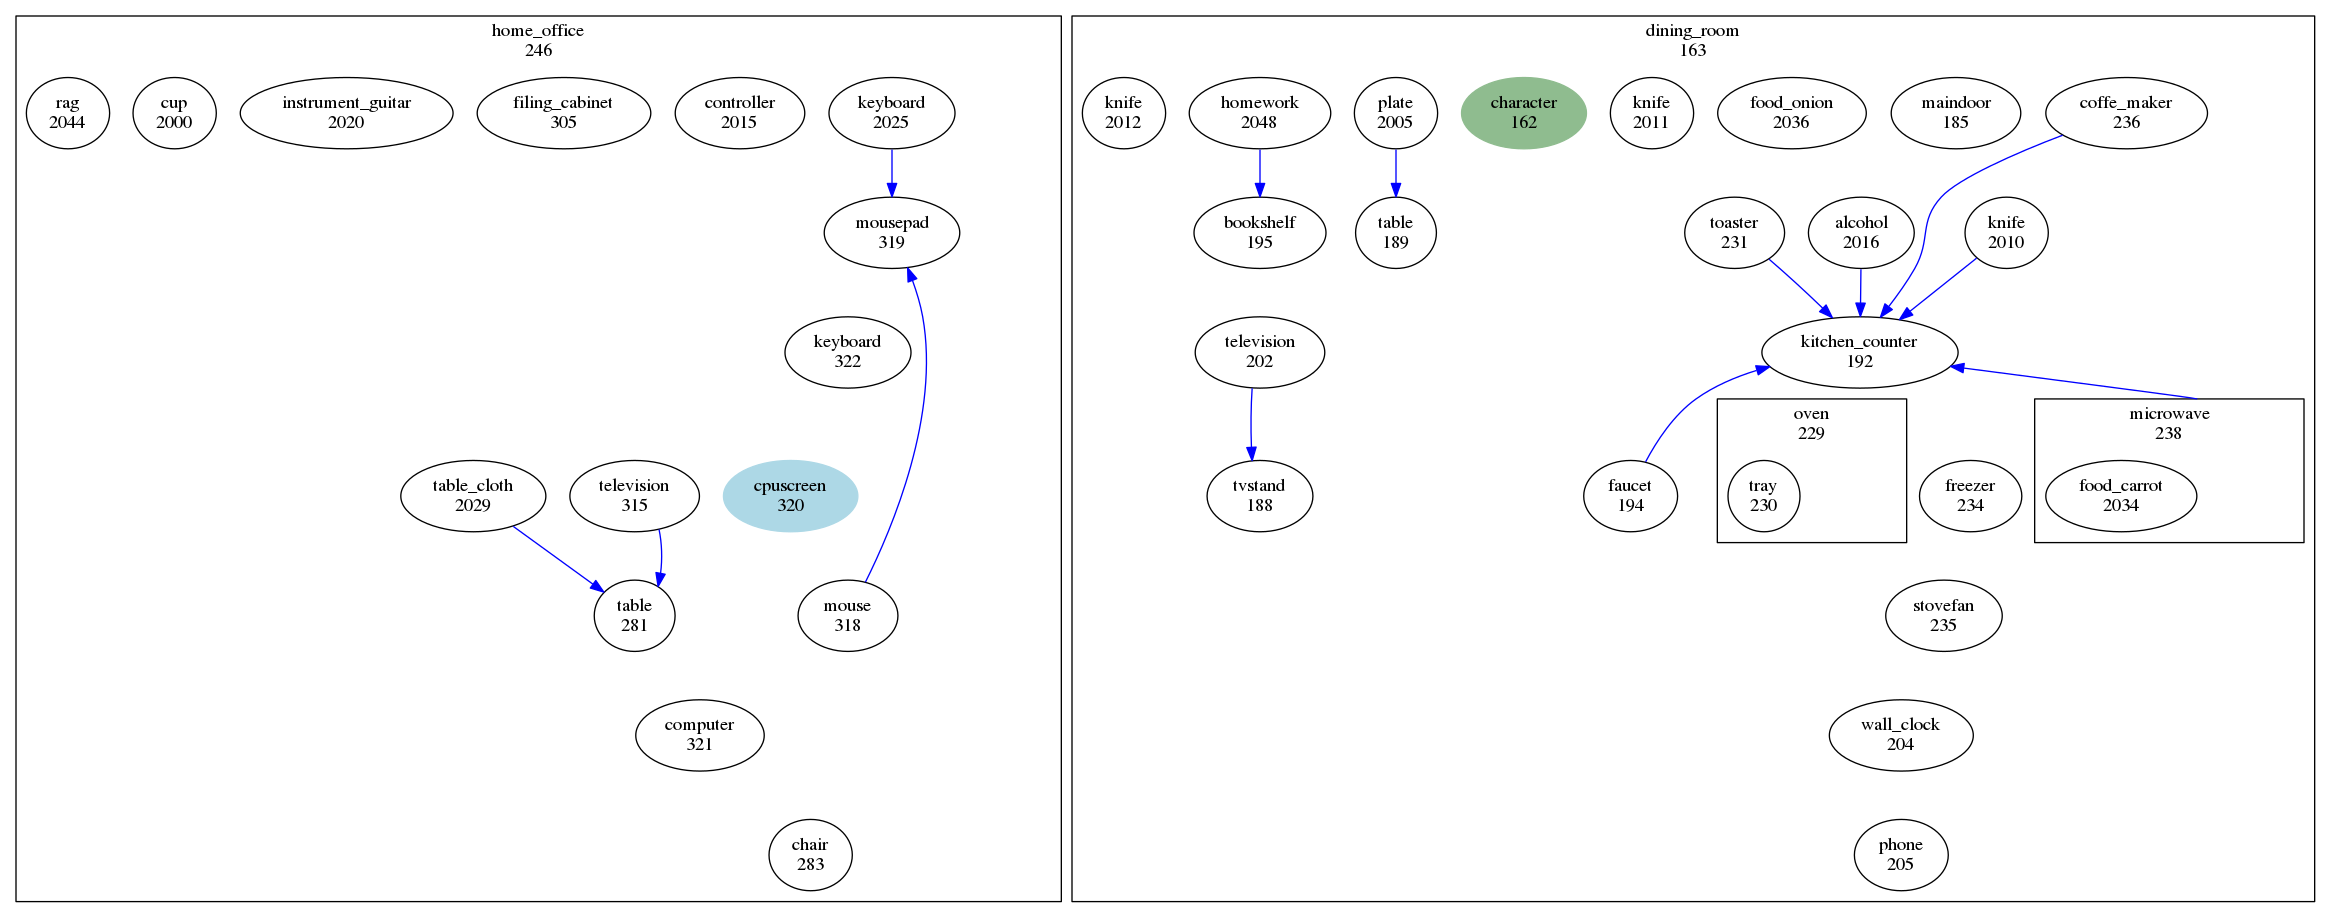

In [144]:
graph = utils_viz.graph2im(gt_state, {320: 'goal', id_agent: 'agent'})
graph.format = 'png'
tmp = graph.view()
display(Image(tmp))

In [145]:
args.pomdp = False
weights = 'logdir/dataset_folder.dataset_toy3_pomdp.False_graphsteps.3/2019-11-06_09.14.31.202175/chkpt/chkpt_49.pt'
state_dict = torch.load(weights)
single_agent.policy_net.load_state_dict(state_dict['model_params'])
curr_env.reset(path_init_env, {0:goal_name})
max_instr = 0
instr = ''
goal_str = 'findnode_320'
while max_instr < 10 and 'stop' not in instr:
    a = one_step_rollout(single_agent.env, goal_str, args.pomdp)
    instr = a[1]
    max_instr += 1
    print(instr)

Loading graph...
Loaded
[walk] <homework> (2048) 
[walk] <dining_room> (163) 
[walk] <homework> (2048) 
[walk] <dining_room> (163) 
[walk] <homework> (2048) 
[walk] <dining_room> (163) 
[walk] <homework> (2048) 
[walk] <dining_room> (163) 
[walk] <homework> (2048) 
[walk] <dining_room> (163) 


In [146]:
args.pomdp = True
weights = 'logdir/dataset_folder.dataset_toy3_pomdp.True_graphsteps.3/2019-11-06_09.13.35.555005/chkpt/chkpt_49.pt'
state_dict = torch.load(weights)
single_agent.policy_net.load_state_dict(state_dict['model_params'])
curr_env.reset(path_init_env, {0:goal_name})
max_instr = 0
instr = ''
goal_str = 'findnode_320'
while max_instr < 10 and 'stop' not in instr:
    a = one_step_rollout(single_agent.env, goal_str, args.pomdp)
    instr = a[1]
    max_instr += 1
    print(instr)

Loading graph...
Loaded
[walk] <home_office> (246) 
[walk] <cpuscreen> (320) 
[stop]  


In [21]:
%load_ext autoreload

In [33]:
%autoreload 2